<a href="https://colab.research.google.com/github/eliseobao/redsm5/blob/main/analysis/lexical/topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling

In [1]:
import re
import nltk
import spacy
import joblib
import gensim
import logging
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import gensim.corpora as corpora

from collections import Counter
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
!python3 -m spacy download en_core_web_sm
nltk.download("stopwords")

/usr/local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words = stopwords.words("english")
stop_words.extend(["rt", "https"])

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR
)

## Reading the data

In [4]:
SYMPTOMS = [
    "NO_SYMPTOMS",
    "DEPRESSED_MOOD",
    "ANHEDONIA",
    "APPETITE_CHANGE",
    "SLEEP_ISSUES",
    "PSYCHOMOTOR",
    "FATIGUE",
    "WORTHLESSNESS",
    "COGNITIVE_ISSUES",
    "SUICIDAL_THOUGHTS",
]

In [5]:
data = pd.read_csv("data/redsm5.csv")

texts_per_symptom = {}
for symptom in SYMPTOMS:
    texts_per_symptom[symptom] = data.loc[
        data["labels"].str.contains(symptom), "text"
    ].tolist()

## We create one LDA model for each symptom

In [6]:
text_data_NO_symptoms = texts_per_symptom["NO_SYMPTOMS"]
text_data_symptoms = (
    texts_per_symptom["DEPRESSED_MOOD"]
    + texts_per_symptom["ANHEDONIA"]
    + texts_per_symptom["APPETITE_CHANGE"]
    + texts_per_symptom["SLEEP_ISSUES"]
    + texts_per_symptom["PSYCHOMOTOR"]
    + texts_per_symptom["FATIGUE"]
    + texts_per_symptom["WORTHLESSNESS"]
    + texts_per_symptom["COGNITIVE_ISSUES"]
    + texts_per_symptom["SUICIDAL_THOUGHTS"]
)


## Tokenizing and preprocess the text data

In [7]:
def sent_to_words(sentences):
    """
    Tokenize sentences into words.

    Parameters:
    - sentences (list): List of sentences to tokenize.

    Yields:
    - list: A list of words for each sentence.
    """
    for sent in sentences:
        sent = re.sub("\s+", " ", str(sent))  # Remove newline chars
        sent = re.sub("'", "", str(sent))  # Remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield sent

In [8]:
# data_words = list(sent_to_words(text_data_NO_symptoms))
data_words = list(sent_to_words(text_data_symptoms))

## Creating n-grams

In [9]:
bigram = gensim.models.Phrases(
    data_words,
    min_count=5,  # Ignores all words and bigrams with total collected count lower than this
    threshold=100,
)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Tokenizing, preprocessing, and lemmatizing each document

In [10]:
def process_words(
    texts, stop_words=stop_words, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]
):
    """
    Tokenize, preprocess, and lemmatize a list of texts.

    Parameters:
    - texts (list): List of tokenized texts to process.
    - stop_words (set): Set of stop words to remove during processing.
    - allowed_postags (list): List of allowed POS (Part-of-Speech) tags.

    Returns:
    - list: List of processed and lemmatized texts.
    """
    # Remove stop words from each document and apply bigram and trigram models
    texts = [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )

    # Remove stopwords once more after lemmatization
    texts_out = [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts_out
    ]
    return texts_out

In [11]:
data_ready = process_words(data_words)

## Creating the dictionary and corpus for topic modeling using Gensim

In [12]:
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

## Creating and training an LDA (Latent Dirichlet Allocation) model using Gensim

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,  # Bag-of-words representation of the documents
    id2word=id2word,  # Dictionary mapping words to unique numerical IDs
    num_topics=4,  # Number of topics to identify
    random_state=100,  # Random seed for reproducibility
    update_every=1,  #  often the model parameters should be updated
    chunksize=10,  # Number of documents to be used in each training chunk
    passes=10,  # Number of passes through the entire corpus during training
    alpha=0.31,  # Parameter controlling the document-topic density
    eta=0.9,  # Parameter controlling the topic-word density
    iterations=1000,  # Maximum number of iterations through the corpus when inferring topic distributions
    per_word_topics=True,
)  # Compute a list of topics, each represented by a list of words and associated probabilities
joblib.dump(lda_model, "lda_model.jl")

['lda_model.jl']

## Calculating the dominant topics and its percentage contribution

In [14]:
def process_row(row_list):
    """
    Process a row of LDA model output.

    Parameters:
    - row_list (list): List representing the output for a document from the LDA model.

    Returns:
    - list: Processed information including the dominant topic number, proportion, and keywords.
    """
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: x[1], reverse=True)

    if row:
        topic_num, prop_topic = row[0]
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        return [int(topic_num), round(prop_topic, 4), topic_keywords]

    return [None, None, None]

In [15]:
sent_topics_df = pd.DataFrame()

# Explicitly iterate through the rows of the LDA model corpus and apply the processing function
for i, row_list in tqdm(enumerate(lda_model[corpus])):
    sent_topics_df = pd.concat(
        [
            sent_topics_df,
            pd.DataFrame(
                [process_row(row_list)],
                columns=["Dominant_Topic", "Topic_Perc_Contrib", "Keywords"],
            ),
        ],
        ignore_index=True,
    )

1292it [00:02, 509.32it/s]


In [16]:
contents = pd.Series(data_ready)
sent_topics_df["Text"] = contents
sent_topics_df = sent_topics_df.dropna(subset=["Dominant_Topic"])

## Visualization

### Distribution of document word counts

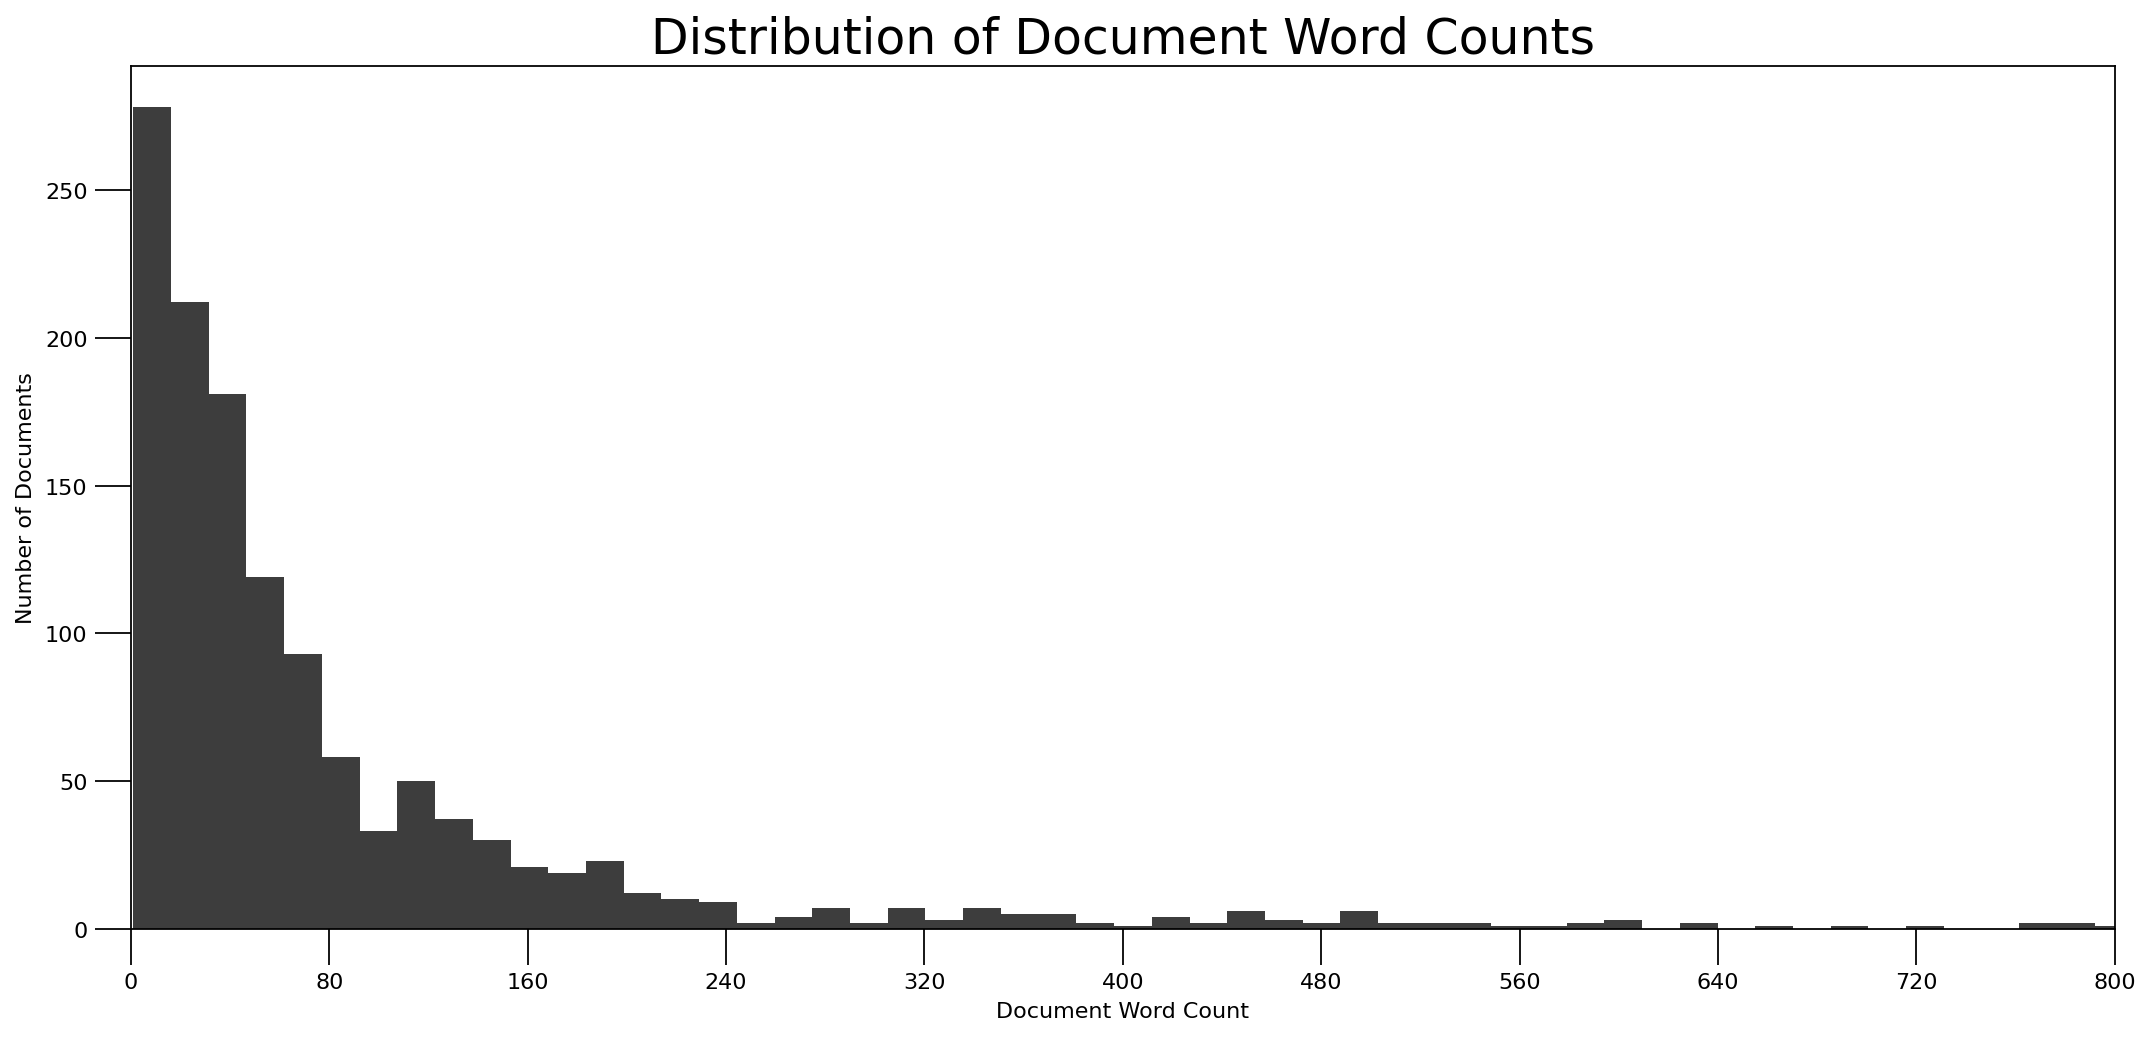

In [17]:
doc_lens = [len(d) for d in sent_topics_df.Text]

plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=200, color="#3d3d3d")
# plt.text(800, 32000, "Mean: " + str(round(np.mean(doc_lens))))
# plt.text(800, 28000, "Median: " + str(round(np.median(doc_lens))))
# plt.text(800, 23000, "Standard deviation: " + str(round(np.std(doc_lens))))
# plt.text(800, 18000, "1% quantile: " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(800, 13000, "99% quantile: " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 800), ylabel="Number of Documents", xlabel="Document Word Count")
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 800, 11))
plt.title("Distribution of Document Word Counts", fontdict=dict(size=22))
plt.show()

### Distribution of document word counts by topic

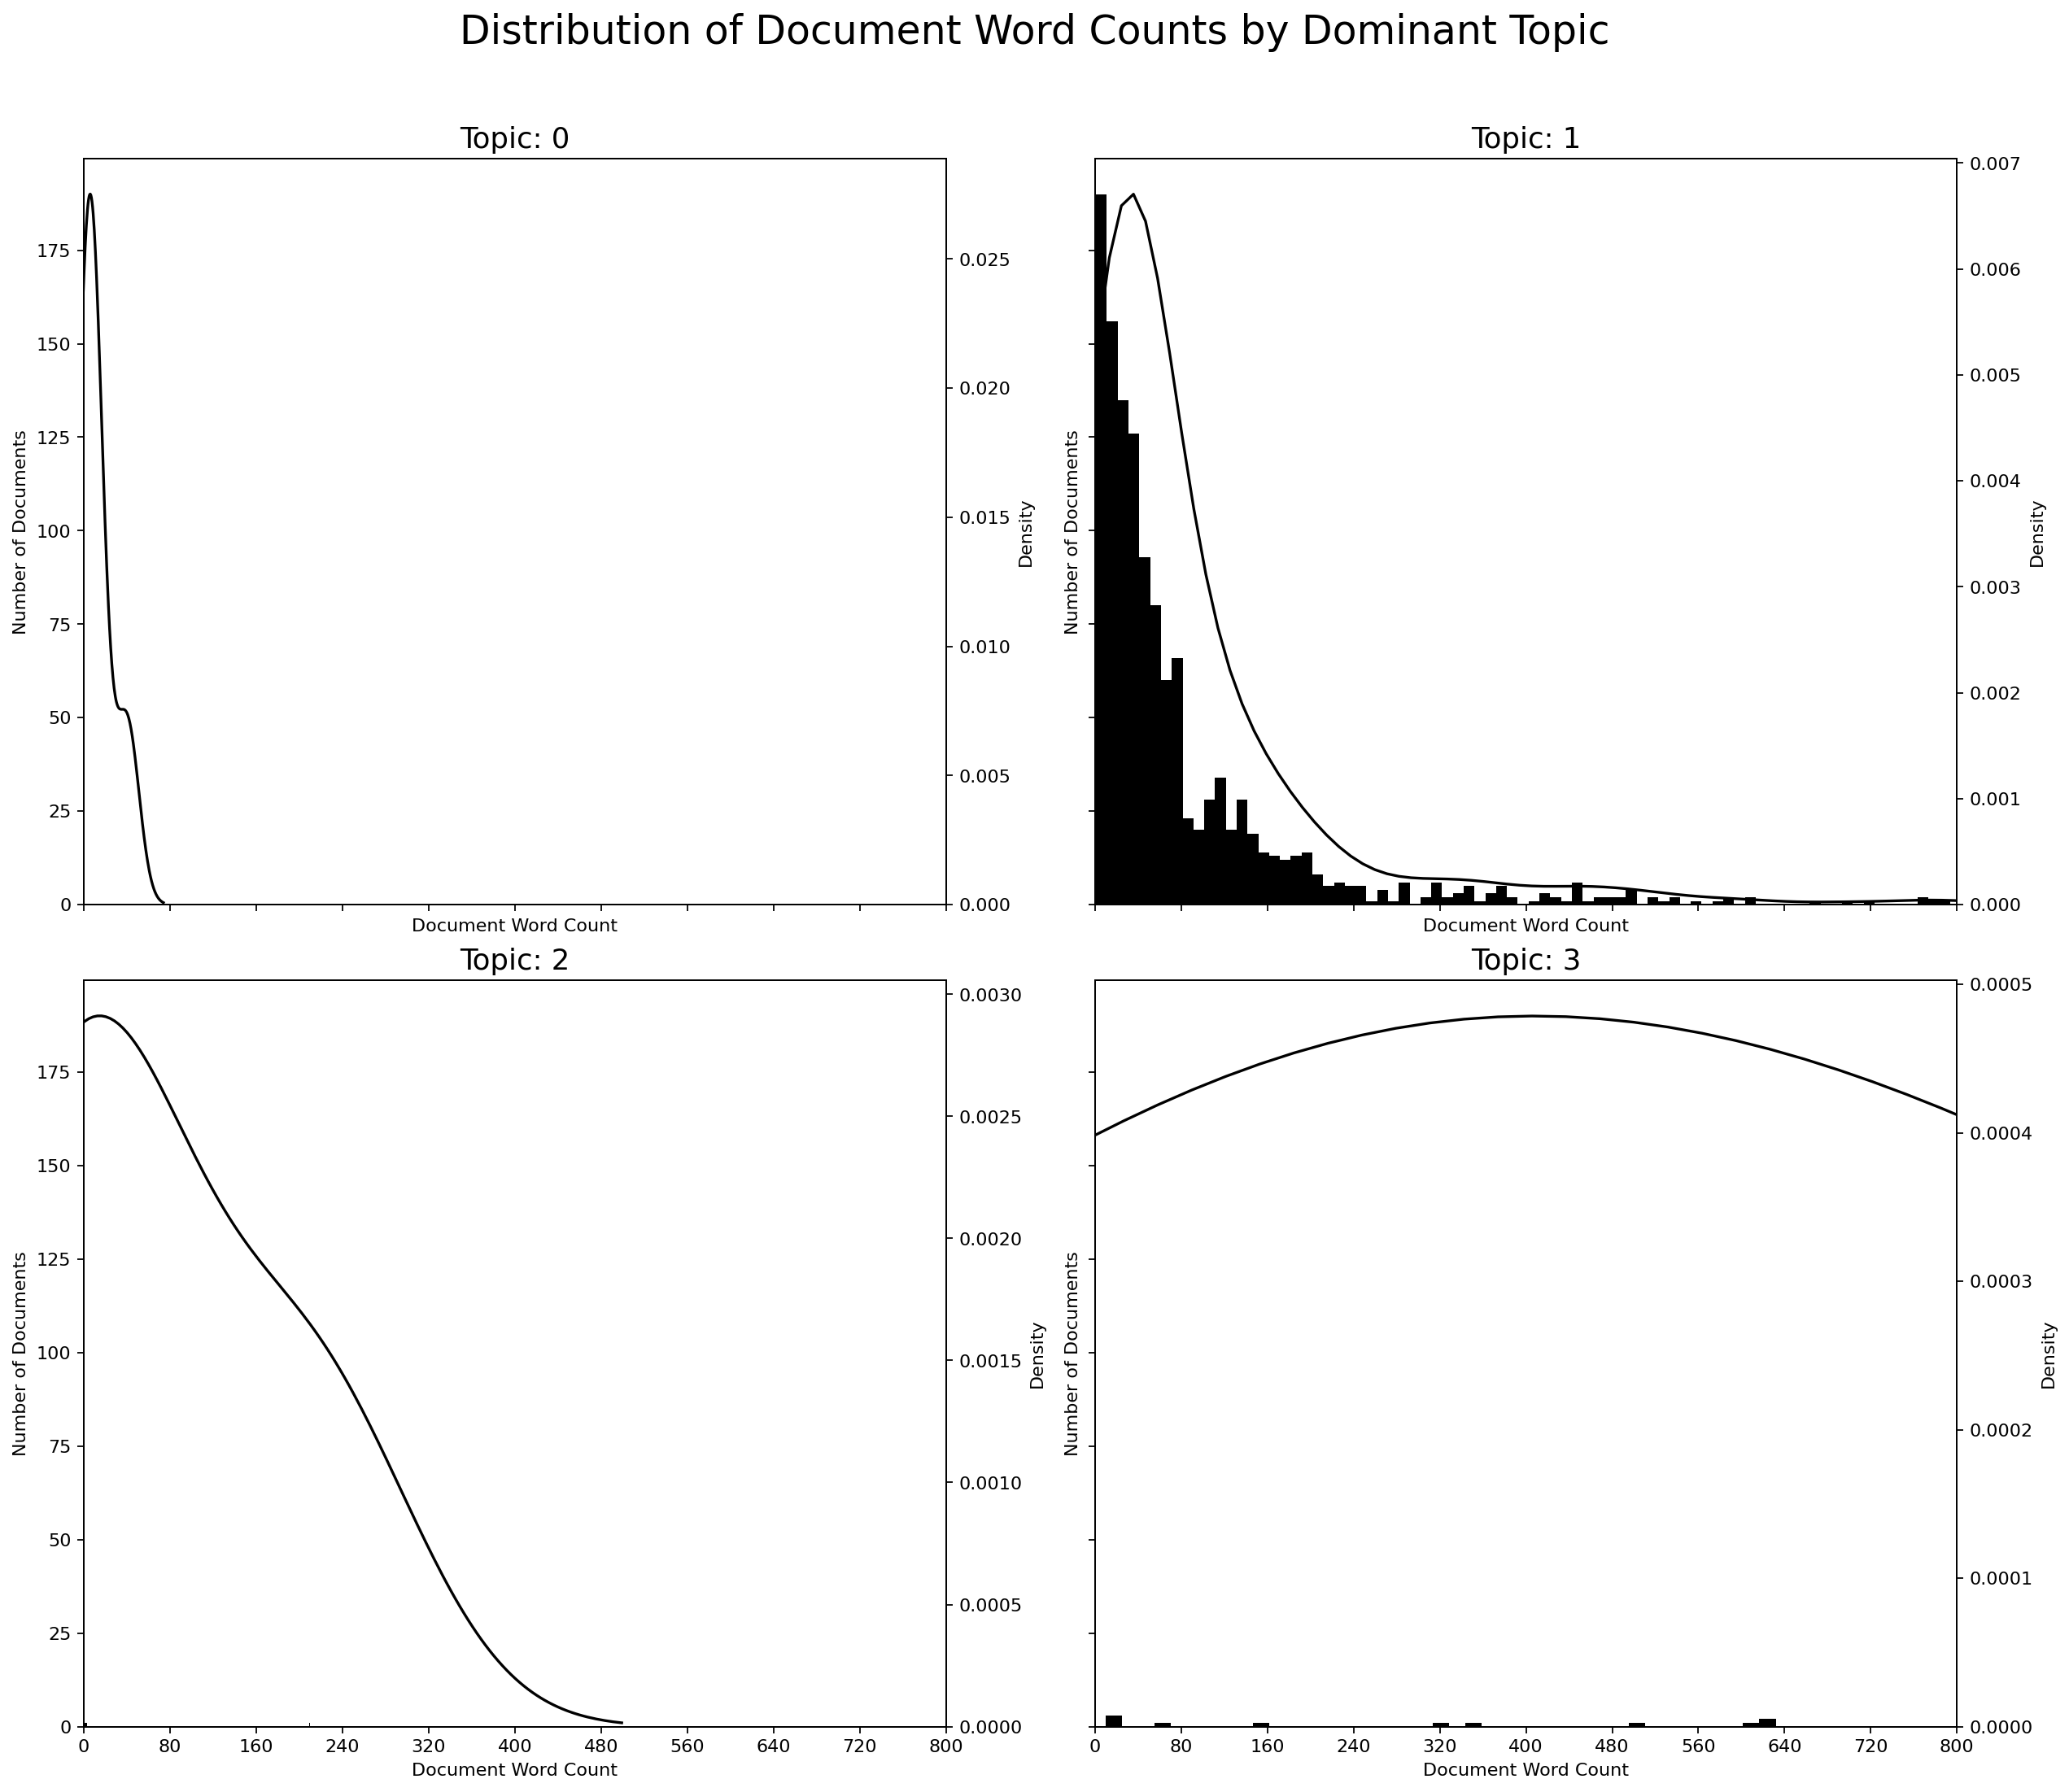

In [18]:
colour = "#000"

fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = sent_topics_df.loc[sent_topics_df.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=200, color=colour)
    ax.tick_params(axis="y", labelcolor=colour, color=colour)
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    ax.set(xlim=(0, 800), xlabel="Document Word Count")
    ax.set_ylabel("Number of Documents", color=colour)
    ax.set_title("Topic: " + str(i), fontdict=dict(size=16, color=colour))


fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 800, 11))
fig.suptitle("Distribution of Document Word Counts by Dominant Topic", fontsize=22)
plt.show()

### Wordcloud

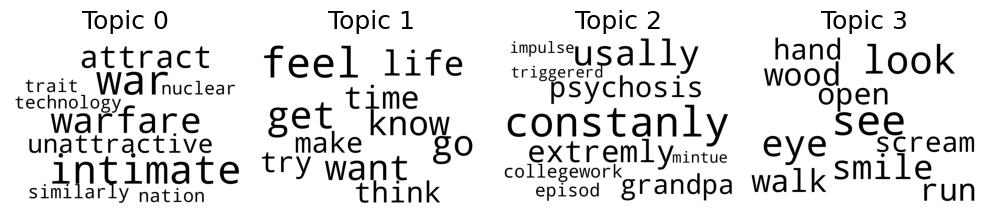

In [19]:
colour = "#000"

cloud = WordCloud(
    stopwords=stop_words,
    background_color="white",
    width=2500,
    height=1800,
    max_words=10,
    colormap="tab10",
    color_func=lambda *args, **kwargs: colour,
    prefer_horizontal=1.0,
)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 4, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=450)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic " + str(i), fontdict=dict(size=18))
    plt.gca().axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("analysis/visuals/wordcloud_symptoms.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Word count and importance of topic keywords

/tmp/ipykernel_704/3656196357.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_704/3656196357.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_704/3656196357.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_704/3656196357.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


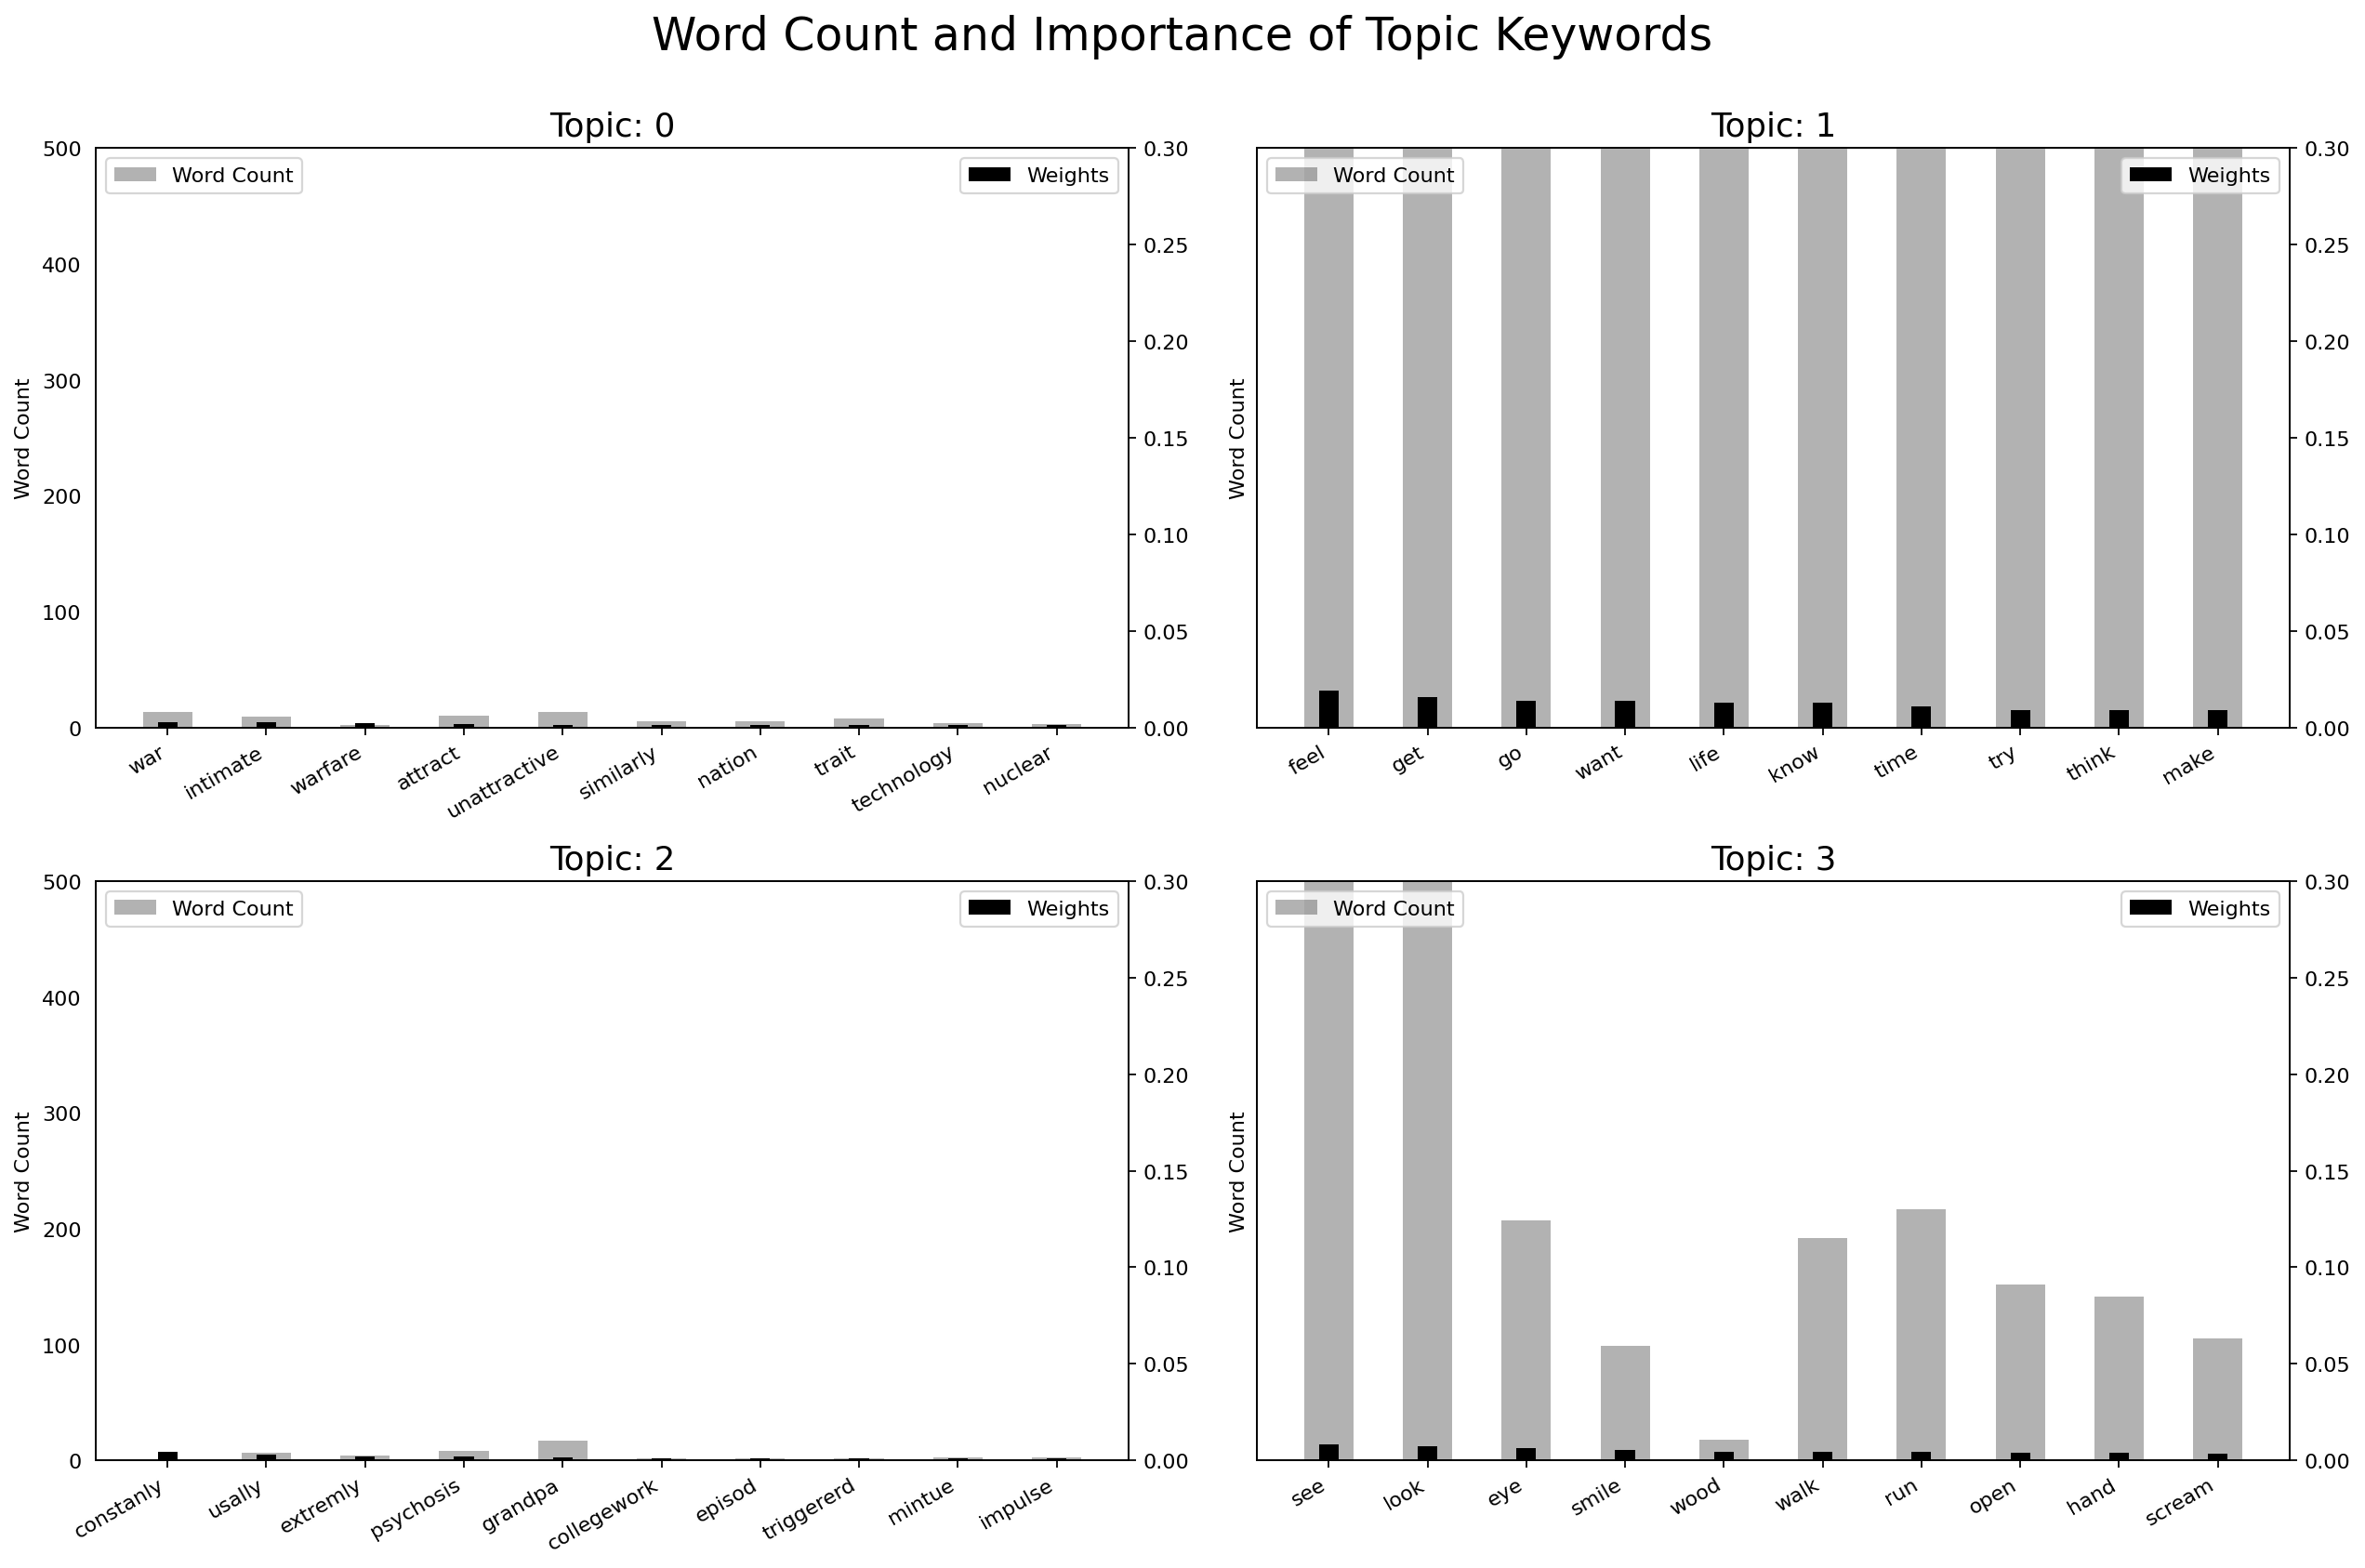

In [20]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=["word", "topic_id", "importance", "word_count"])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
colour = "#000"

topics = [0, 1, 2, 3]

for i, ax in enumerate(axes.flatten()):
    ax.bar(
        x="word",
        height="word_count",
        data=df.loc[df.topic_id == topics[i], :],
        color=colour,
        width=0.5,
        alpha=0.3,
        label="Word Count",
    )
    ax_twin = ax.twinx()
    ax_twin.bar(
        x="word",
        height="importance",
        data=df.loc[df.topic_id == topics[i], :],
        color=colour,
        width=0.2,
        label="Weights",
    )
    ax.set_ylabel("Word Count", color=colour)
    ax_twin.set_ylim(0, 0.3)
    ax.set_ylim(0, 500)
    ax.set_title("Topic: " + str(i), color=colour, fontsize=16)
    ax.tick_params(axis="y", left=False)
    ax.set_xticklabels(
        df.loc[df.topic_id == topics[i], "word"],
        rotation=30,
        horizontalalignment="right",
    )
    ax.legend(loc="upper left")
    ax_twin.legend(loc="upper right")

fig.tight_layout(w_pad=2)
fig.suptitle("Word Count and Importance of Topic Keywords", fontsize=22, y=1.05)
plt.show()

### t-SNE clustering

In [21]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.5]
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
# tsne_model = TSNE(
#     n_components=2, verbose=1, random_state=0, angle=0.99, init="pca", perplexity=5
# )

tsne_model = TSNE(n_components=2, learning_rate=50, n_iter=300, verbose=1, random_state=0, angle=.5, init='pca', perplexity=35)
tsne_lda = tsne_model.fit_transform(arr)

/usr/local/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.001s...
[t-SNE] Computed neighbors for 1280 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 0.001105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.274551
[t-SNE] KL divergence after 300 iterations: 0.541479


#### Plot

/usr/local/lib/python3.11/site-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


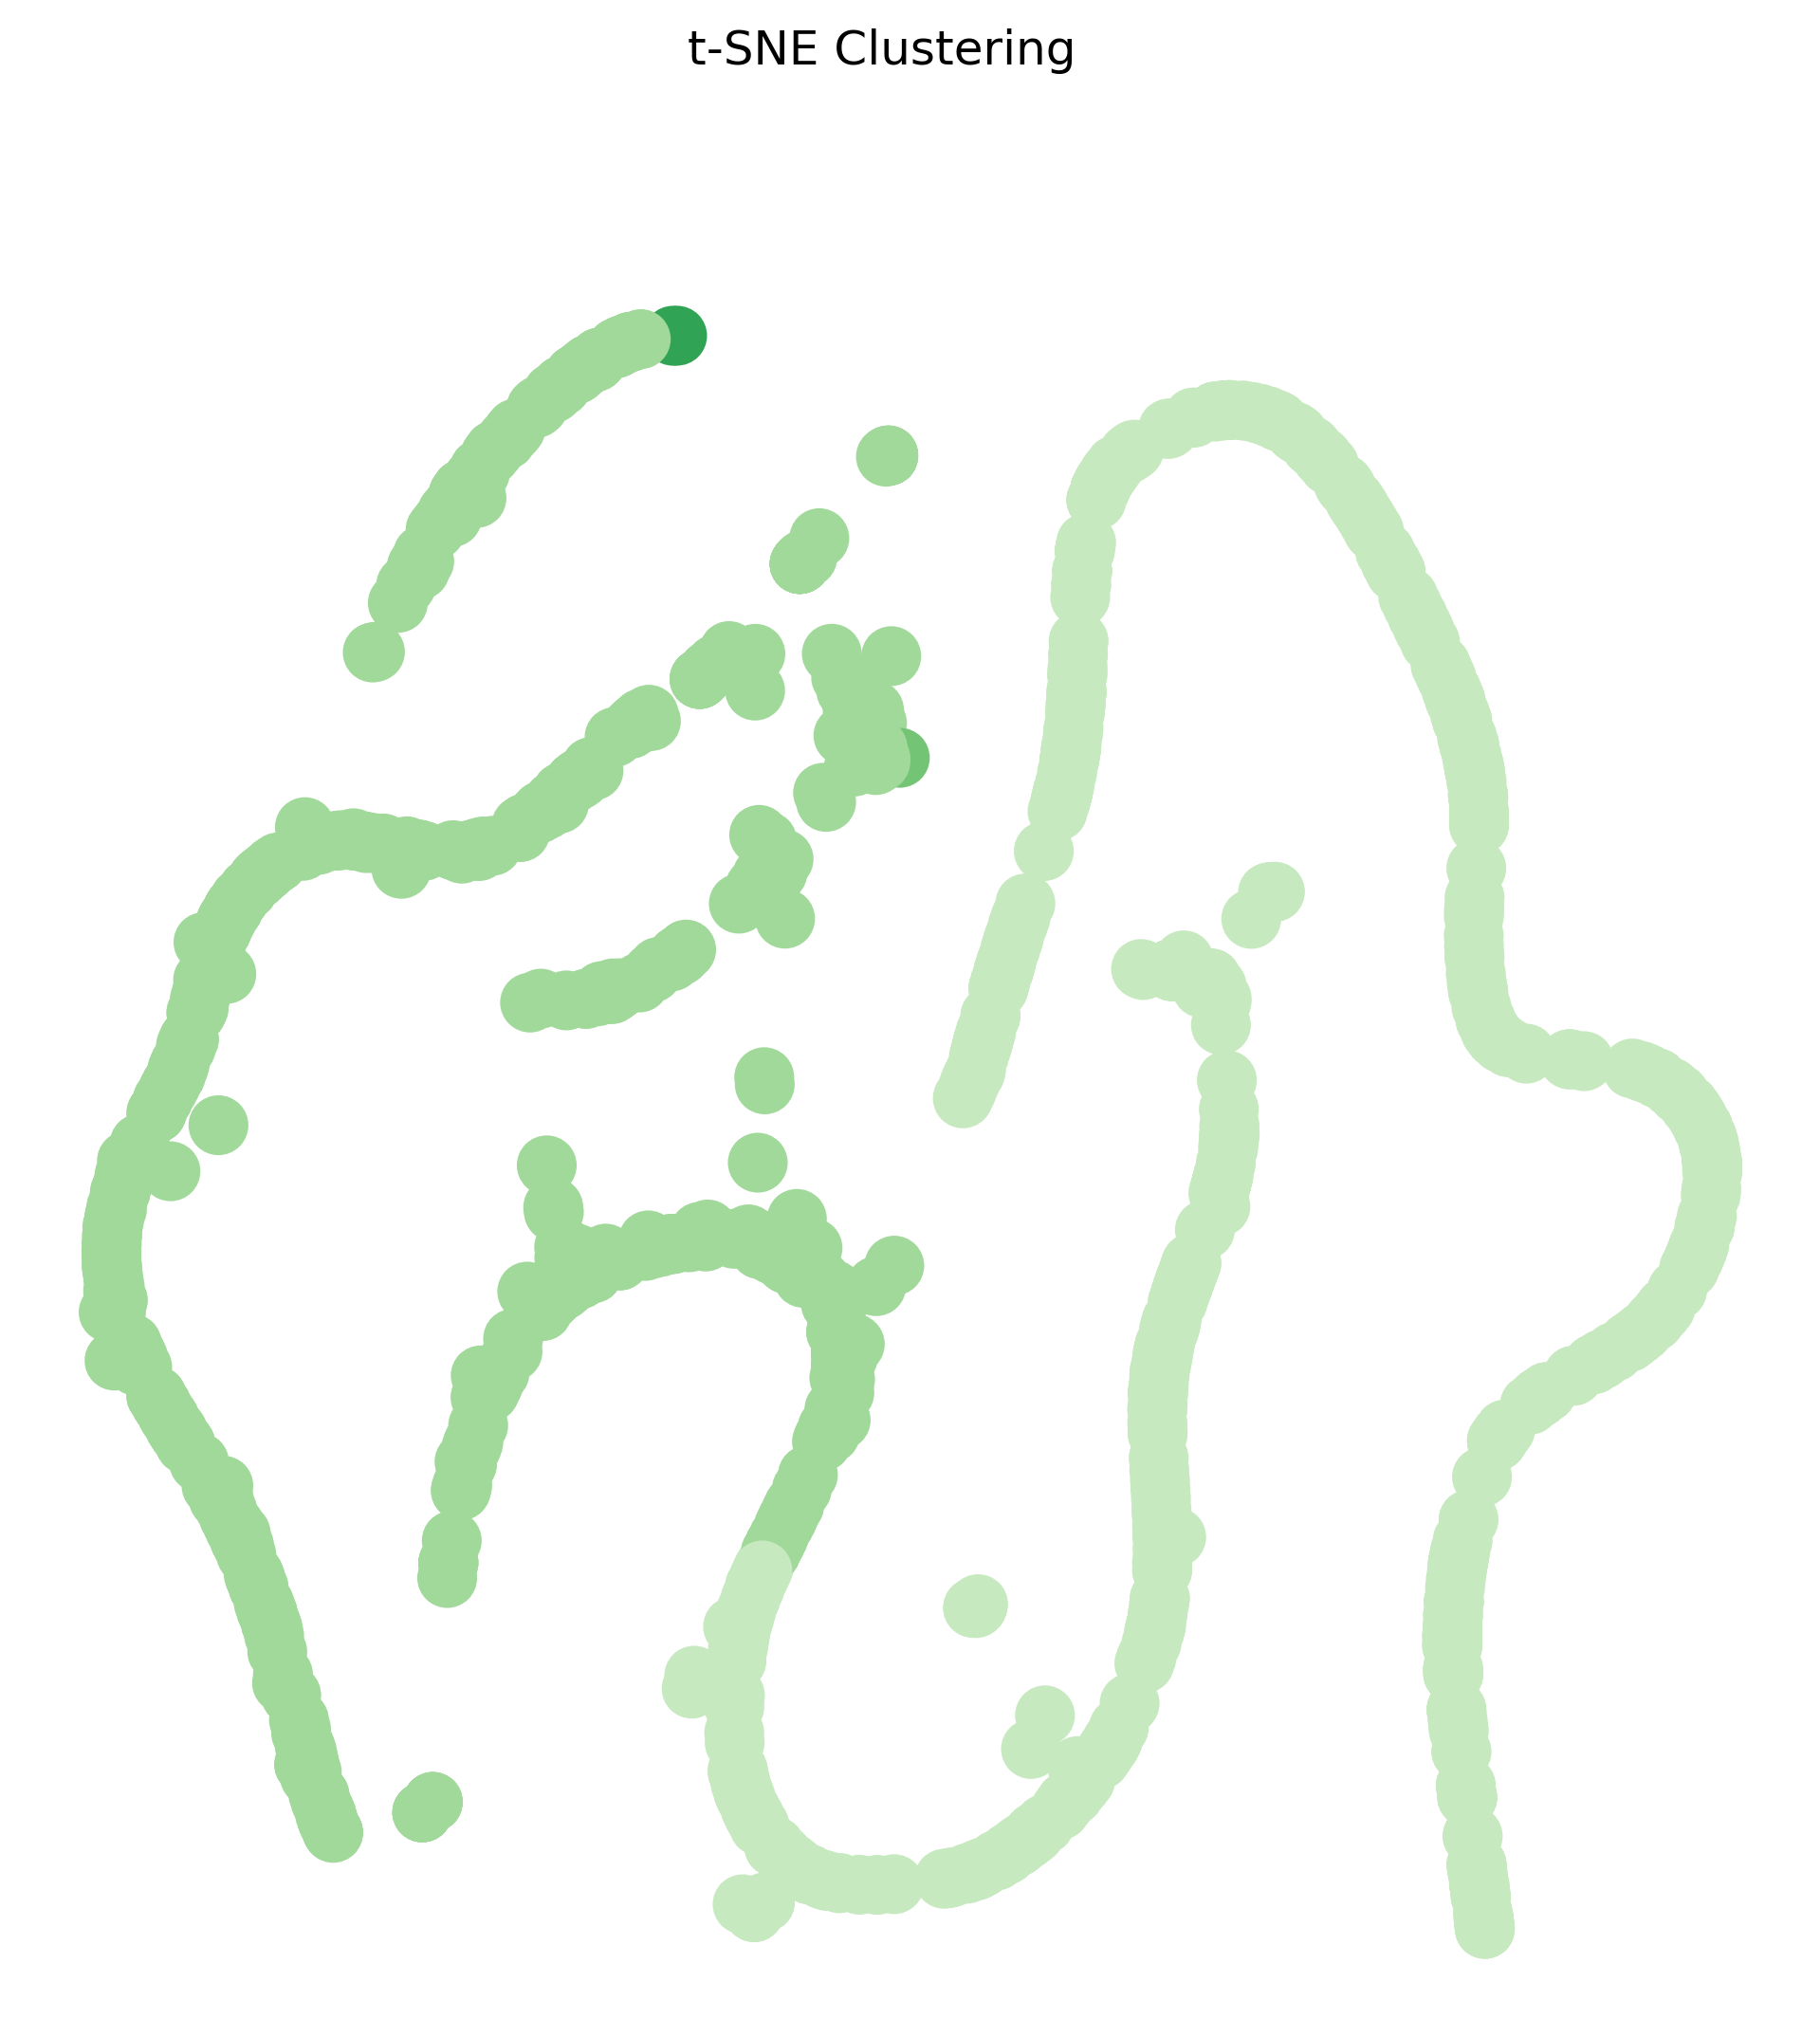

In [22]:
colors = np.array(["#c7e9c0", "#a1d99b", "#74c476", "#31a354", "#006d2c", "#003816"])
plt.figure(figsize=(8, 8), dpi=300)
scatter = plt.scatter(
    tsne_lda[:, 0], tsne_lda[:, 1], c=colors[topic_num % len(colors)], s=200
)

handles, _ = scatter.legend_elements(prop="colors")
plt.suptitle("t-SNE Clustering")
plt.axis("off")
plt.show()